In [1]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import sys, os
from time import time

import pandas as pd
import numpy as np

from scipy.stats import spearmanr

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '..'))
sns.set_style('darkgrid')
idx = pd.IndexSlice
YEAR = 252

In [2]:
class MultipleTimeSeriesCV:
    def __init__(self, n_splits=3, train_period_length=126, test_period_length=21, lookahead=None, shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx, test_start_idx, test_end_idx])

        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start]) & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start]) & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [3]:
with pd.HDFStore('data/data.h5') as store:
    data = (store['model_data'].dropna().drop(['open', 'close', 'low', 'high'], axis=1))
data = data.drop([c for c in data.columns if 'year' in c or 'lag' in c], axis=1)

In [5]:
data.tail()

volume  dollar_vol  dollar_vol_1m  dollar_vol_rank  \
ticker date                                                              
ZUMZ   2017-11-22  265.795   4943.7870    5761.835586           1545.0   
       2017-11-24  208.610   3974.0205    5720.920719           1536.0   
       2017-11-27  443.388   8513.0496    5915.601226           1518.0   
       2017-11-28  689.911  13867.2111    6376.928660           1491.0   
       2017-11-29  724.964  15115.4994    6934.407026           1470.0   

                         rsi   bb_high   bb_mid    bb_low       atr      macd  \
ticker date                                                                     
ZUMZ   2017-11-22  55.097028  0.038098  18.1600  0.084078 -0.811466  0.561643   
       2017-11-24  58.668474  0.020911  18.2100  0.104159 -0.743366  0.580630   
       2017-11-27  59.815803  0.018437  18.2450  0.111935 -0.572586  0.605366   
       2017-11-28  65.927314 -0.010605  18.3525  0.151383 -0.449853  0.716139   
       2017-11-29  70.019337 -0.025148  18.5250  0.181312 -0.371734  0.876695   

                   ...  consumer_durables  consumer_non-durables  \
ticker date        ...                                             
ZUMZ   2017-11-22  ...                  0                      0   
       2017-11-24  ...                  0                      0   
       2017-11-27  ...                  0                      0   
       2017-11-28  ...                  0                      0   
       2017-11-29  ...                  0                      0   

                   consumer_services  energy  finance  health_care  \
ticker date                                                          
ZUMZ   2017-11-22                  1       0        0            0   
       2017-11-24                  1       0        0            0   
       2017-11-27                  1       0        0            0   
       2017-11-28                  1       0        0            0   
       2017-11-29                  1       0        0            0   

                   miscellaneous  public_utilities  technology  transportation  
ticker date                                                                     
ZUMZ   2017-11-22              0                 0           0               0  
       2017-11-24              0                 0           0               0  
       2017-11-27              0                 0           0               0  
       2017-11-28              0                 0           0               0  
       2017-11-29              0                 0           0               0  

[5 rows x 42 columns]

In [6]:
data = data[data.dollar_vol_rank<100]

y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

In [11]:
train_period_length = 63 # 3 months
test_period_length = 10 # 2 weeks
lookahead =1
n_splits = int(3 * YEAR/test_period_length)

cv = MultipleTimeSeriesCV(n_splits=n_splits, test_period_length=test_period_length,
                          lookahead=lookahead, train_period_length=train_period_length)

target = f'target_{lookahead}d'
y.loc[:, 'label'] = (y[target] > 0).astype(int)
y.label.value_counts()

1    56486
0    53189
Name: label, dtype: int64

In [16]:
y.label.tail()

ticker  date      
ZTS     2014-11-28    0
        2014-12-01    1
        2014-12-02    1
        2014-12-03    0
        2014-12-04    0
Name: label, dtype: int32

In [17]:
Cs = np.logspace(-5, 5, 11)
cols = ['C', 'date', 'auc', 'ic', 'pval']

In [21]:
Cs

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])

In [18]:
%%time
log_coeffs, log_scores, log_predictions = {}, [], []
for C in Cs:
    print(C)
    # LogisticRegression: lower C higher regularization
    # C(cost function): inverse of regularization strength
    # penalty='l1' or 'l2'  regularization(default:l2)
    model = LogisticRegression(C=C, fit_intercept=True, random_state=42, n_jobs=-1)

    pipe = Pipeline([ ('scaler', StandardScaler()), ('model', model)])
    ics = aucs = 0
    start = time()
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y.label.iloc[train_idx]
        pipe.fit(X=X_train, y=y_train)
        X_test, y_test = X.iloc[test_idx], y.label.iloc[test_idx]
        actuals = y[target].iloc[test_idx]
        if len(y_test) < 10 or len(np.unique(y_test)) < 2:
            continue
        y_score = pipe.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_score=y_score, y_true=y_test)
        actuals = y[target].iloc[test_idx]
        ic, pval = spearmanr(y_score, actuals)

        log_predictions.append(y_test.to_frame('labels').assign(predicted=y_score, C=C, actuals=actuals))
        date = y_test.index.get_level_values('date').min()
        log_scores.append([C, date, auc, ic * 100, pval])
        coeffs.append(pipe.named_steps['model'].coef_)
        ics += ic
        aucs += auc
        if i % 10 == 0:
            print(f'\t{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {aucs/i:>7.2%}')

    log_coeffs[C] = np.mean(coeffs, axis=0).squeeze()

1e-05
	 12.0 | 010 |  -0.27% |  50.42%
	 22.2 | 020 |   2.04% |  51.89%
	 33.4 | 030 |   2.92% |  52.01%
	 44.6 | 040 |   3.34% |  51.98%
	 55.7 | 050 |   4.01% |  52.44%
	 67.0 | 060 |   3.99% |  52.26%
	 78.1 | 070 |   4.75% |  52.59%
0.0001
	 11.2 | 010 |  -0.03% |  50.61%
	 22.3 | 020 |   2.40% |  52.10%
	 33.4 | 030 |   3.28% |  52.27%
	 44.5 | 040 |   3.38% |  52.08%
	 55.6 | 050 |   4.05% |  52.52%
	 66.7 | 060 |   4.04% |  52.32%
	 77.8 | 070 |   4.84% |  52.66%
0.001
	 11.2 | 010 |   0.46% |  50.95%
	 22.3 | 020 |   2.68% |  52.23%
	 33.5 | 030 |   3.63% |  52.49%
	 44.7 | 040 |   3.19% |  52.06%
	 55.8 | 050 |   3.86% |  52.49%
	 66.9 | 060 |   4.04% |  52.32%
	 78.1 | 070 |   4.88% |  52.69%
0.01
	 11.2 | 010 |   0.70% |  51.10%
	 22.4 | 020 |   2.43% |  52.01%
	 33.5 | 030 |   3.61% |  52.39%
	 44.7 | 040 |   3.09% |  51.92%
	 55.9 | 050 |   3.90% |  52.44%
	 67.0 | 060 |   4.14% |  52.28%
	 78.2 | 070 |   4.88% |  52.62%
0.1
	 11.2 | 010 |   0.65% |  51.07%
	 22.3 | 020 | 

In [28]:
log_predictions.tail()
# log_coeffs

labels  predicted         C   actuals
ticker date                                             
XOM    2014-12-16       1   0.495484  100000.0  0.030205
       2014-12-17       1   0.465964  100000.0  0.024040
       2014-12-18       1   0.476350  100000.0  0.027205
       2014-12-19       0   0.466757  100000.0 -0.003311
       2014-12-22       1   0.489555  100000.0  0.013500

In [19]:
log_scores = pd.DataFrame(log_scores, columns=cols)
log_scores.to_hdf('data/data.h5', 'logistic/scores')

log_coeffs = pd.DataFrame(log_coeffs, index=X.columns).T
log_coeffs.to_hdf('data/data.h5', 'logistic/coeffs')

log_predictions = pd.concat(log_predictions)
log_predictions.to_hdf('data/data.h5', 'logistic/predictions')

log_scores = pd.read_hdf('data/data.h5', 'logistic/scores')

In [20]:
log_scores.tail()

,C,date,auc,ic,pval
820,100000.0,2015-02-06,0.565541,13.256104,0.000029
821,100000.0,2015-01-23,0.491174,-2.630411,0.408386
822,100000.0,2015-01-08,0.499241,0.056892,0.985736
823,100000.0,2014-12-23,0.501836,4.534953,0.153920
824,100000.0,2014-12-09,0.495897,-1.289246,0.685363


In [31]:
log_scores.groupby('C').auc.describe()

,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0.00001,75.0,0.524224,0.036165,0.433251,0.499613,0.521674,0.545554,0.625854
0.00010,75.0,0.524952,0.035504,0.444769,0.504354,0.523535,0.544725,0.635646
0.00100,75.0,0.525420,0.036050,0.438831,0.503380,0.521717,0.545229,0.641384
0.01000,75.0,0.524957,0.036439,0.435889,0.499990,0.522789,0.550733,0.642237
0.10000,75.0,0.523378,0.035923,0.427314,0.497781,0.522663,0.546358,0.622452
1.00000,75.0,0.522957,0.035852,0.424971,0.499003,0.520896,0.546347,0.617220
10.00000,75.0,0.522910,0.035833,0.424831,0.499171,0.520794,0.546330,0.616478
100.00000,75.0,0.522907,0.035829,0.424870,0.499171,0.520798,0.546334,0.616397
1000.00000,75.0,0.522903,0.035830,0.424870,0.499171,0.520802,0.546300,0.616384


In [43]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}', horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes)

best_auc: 0.001 
                   mean    median
C                               
0.00001       0.524224  0.521674
0.00010       0.524952  0.523535
0.00100       0.525420  0.521717
0.01000       0.524957  0.522789
0.10000       0.523378  0.522663
1.00000       0.522957  0.520896
10.00000      0.522910  0.520794
100.00000     0.522907  0.520798
1000.00000    0.522903  0.520802
10000.00000   0.522904  0.520806
100000.00000  0.522904  0.520806


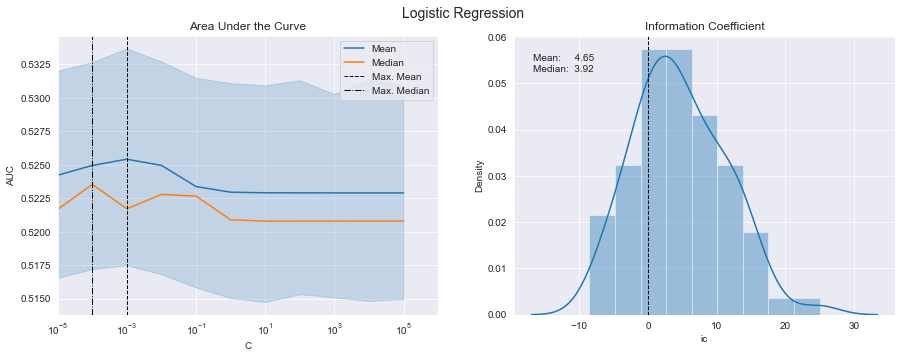

In [44]:
fig, axes= plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(x='C', y='auc', data=log_scores, estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = log_scores.groupby('C').auc.agg(['mean', 'median'])
best_auc = by_alpha['mean'].idxmax()
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median', xlim=(10e-6, 10e5))
axes[0].axvline(best_auc, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_ylabel('AUC')
axes[0].set_xscale('log')
axes[0].set_title('Area Under the Curve')

plot_ic_distribution(log_scores[log_scores.C==best_auc], ax=axes[1])
axes[1].set_title('Information Coefficient')

fig.suptitle('Logistic Regression', fontsize=14)
fig.subplots_adjust(top=.9);
print(f'best_auc: {best_auc} \n {by_alpha}')